In [1]:
from __future__ import print_function, division # Python 3 printing and division

import pandas as pd
import numpy as np
import seaborn as sns
import os, shutil, glob

# from sklearn.utils.extmath import cartesian
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.ticker as plticker
# from matplotlib.backends.backend_pdf import PdfPages
# import matplotlib.cm as cm
# import matplotlib.mlab as mlab
# from matplotlib.mlab import griddata
%matplotlib inline

In [2]:
from SALib.sample import saltelli, latin
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

import pystran

In [7]:
def reshape_files(case_dir,case_name,sim_type,num_scenarios):
    """
    Takes in WEST output files (Steady State.out.txt or Dynamic.out.txt) in a directory (case_dir),
    reads them and arranges them per output variable (instead of per scenario) in a dictionary
    """
    #Initialise everything by reading first file 
    file_name = '%04d'%0 + '_' + case_name + '.' + sim_type + '.' + 'Simul.out.txt'
    output = pd.read_csv(os.path.join(case_dir, file_name), sep='\t')
    result_dict = {k: pd.DataFrame() for k in output.columns}
    result_units = {tag: unit for tag,unit in zip(output.columns,output.loc[0])}
    
    for var_name in result_dict.keys():
        result_dict[var_name]['scen'+'%d'%0] = output[var_name][1:].astype(float)
    
    #Loop over the rest of the files, once per file and once per output variable
    for i in range(1,num_scenarios):
        file_name = '%04d'%i + '_' + case_name + '.' + sim_type + '.' + 'Simul.out.txt'
        output = pd.read_csv(os.path.join(case_dir, file_name), sep='\t')
        for var_name in result_dict.keys():
            previous_data = result_dict[var_name]
            new_data = pd.DataFrame({'scen'+'%d'%i : output[var_name][1:].astype(float)})
            result_dict[var_name] = pd.concat([previous_data,new_data],axis=1)
    
    return result_dict, result_units

def run_GSA(scenario, case_dir, case_name, save_dir, experiment_type, timeout_duration):
    scen_id = scenario[0]
    parameter_dict = scenario[1]
    #parameter_dict=dict(zip(parsets2run.columns.values,values))

    scen = py2WEST.WestWrapper(case_dir, case_name, save_dir, scen_id, parameter_dict,
                               experiment_type=experiment_type, timeout=timeout_duration)
    scen.run_west()
    
    #include reshape files function here, so this function is also executed on cluster
    return [scen_id, scen.succes]

# Sample preparation comparison

## SALib param preparation

In [669]:
problem = {
  'num_vars': 2,
  'names': ['K_O_A1Lysis', 'K_O_A2Lysis'],
  'bounds': [[0.1, 1], [0.1, 1]]
}

# Generate samples
param_values = saltelli.sample(problem, 60000, calc_second_order=True)

In [670]:
param_values.shape

(360000, 2)

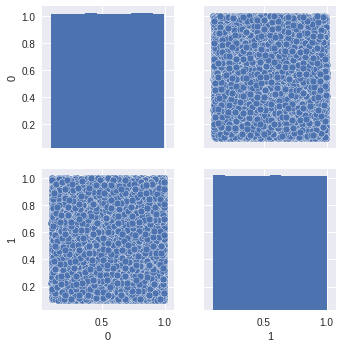

In [106]:
sns.pairplot(pd.DataFrame(param_values))

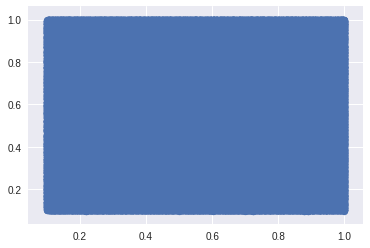

In [677]:
# plt.subplots(figsize=(10,10))
plt.scatter(param_values[:,0],  param_values[:,1])

## pySTrAN param preparation

In [672]:
Xi = [(0.1,1,r'$X_1$'),(0.1,1,r'$X_2$')]    

#prepare model class
goat=pystran.GlobalOATSensitivity(Xi)

#prepare the parameter sample
goat.PrepareSample(60000,0.01, 
                       samplemethod='Sobol', 
                       numerical_approach='central')

The analysed model is externally run
Last seed pointer is  60001


In [673]:
goat.parset2run.shape

(240000, 2)

In [674]:
pd.DataFrame(goat.parset2run).head()

,0,1
0,0.55550,0.5500
1,0.54450,0.5500
2,0.55000,0.5555
3,0.55000,0.5445
4,0.78275,0.3250


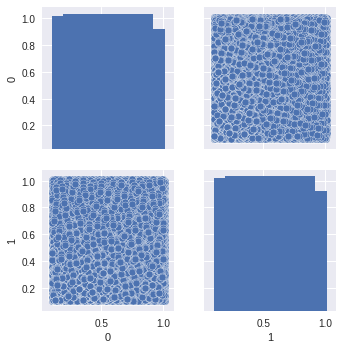

In [675]:
sns.pairplot(pd.DataFrame(goat.parset2run))

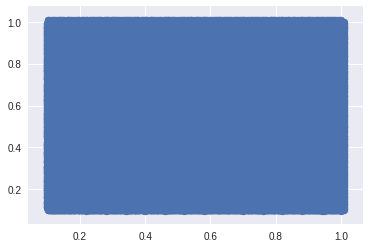

In [676]:
# plt.subplots(figsize=(10,10))
plt.scatter(goat.parset2run[:,0],  goat.parset2run[:,1])

# py2west section

<font size=3> <b> use this for running a simulation on the eraser and then analize the results in the next sections

In [694]:
from __future__ import print_function, division # Python 3 printing and division

import pandas as pd
import numpy as np
import seaborn as sns
import os, shutil, glob
import py2WEST

from sklearn.utils.extmath import cartesian
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as plticker
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from matplotlib.mlab import griddata
%matplotlib inline

In [695]:
import ipyparallel as ipp
c = ipp.Client()

In [696]:
%%px --local
import subprocess                           # Run commands in bash
import signal                               # Needed to limit calculation time per simulation 
import shutil
import xml.etree.ElementTree as etxml
import lxml
import os
import py2WEST                              # imported as py2WEST; parse_xml file is saved in py2WEST folder as a package 
import dill
import pickle
from ipykernel import serialize
serialize.pickle = pickle

In [697]:
dview = c[:]                                    # Make directView of all clients, used to parse data/objects to cores
lview = c.load_balanced_view()             # Make balancedView of all clients, used for dynamic calculations

In [698]:
pywest_dir = './'
case_dir = '/home/data/gbelland/gitRepos/EHV_GSA/WEST16_DRYW_N2O/'
save_dir = '/home/data/gbelland/gitRepos/EHV_GSA/WEST16_DRYW_N2O/'

In [699]:
case_name = 'Eindhoven'
experiment_type = r"steady state"#r"dynamic"#
timeout_duration = 500 #s
default_output = None

<font size=3> <b> N.B.: for global parameters insert the parameter name without point before it

## either SALib sampling..

In [462]:
# try either this or the following
problem = {
  'num_vars': 2,
  'names': ['K_IO_AOBden', 'K_SO_AOBden'],
  'bounds': [[0.1, 5], [0.1, 6]]
}

# Generate samples
param_values = latin.sample(problem, 8)#, calc_second_order=True)
columns=problem['names'] 

## ..or pySTrAn sampling

In [690]:
Xi = [(0.06, 1.74, 'K_O_A1Lysis'), (0.151, 0.739, 'K_O_A2Lysis'), (0.0028, 0.3052, 'b_A1'),
     (0.0028, 0.3052, 'b_A2'), (0.14, 0.25, 'Y_A1'), (0.042,  0.258, 'Y_A2'),
     (0.0009, 1.1, 'K_FA_AOBden'), (0.0000005, 0.003, 'K_FNA_AOBden'), (0.01, 11, 'K_IO_AOBden'),
     (0.08, 4.3, 'K_SNO_AOBden'), (0.01, 13.2, 'K_SO_AOBden'), (0.025, 0.685, 'n1_AOB'), (0.025, 0.685, 'n2_AOB')]

# Xi = [(0.1,5,'K_IO_AOBden'),(0.1,6,'K_SO_AOBden')]    

#prepare model class
goat=pystran.GlobalOATSensitivity(Xi)

#prepare the parameter sample
goat.PrepareSample(1,0.01, 
                       samplemethod='lh', 
                       numerical_approach='central')
columns=[]
for i in Xi:
    columns=np.append(columns, i[2]).tolist()
param_values = goat.parset2run

The analysed model is externally run


## simulate with py2WEST

In [700]:
param_values.shape

(26, 13)

In [701]:
parasets = pd.DataFrame(param_values, columns=columns)

In [702]:
scenario = []
for row in parasets.index:
    scenario.append([row, py2WEST.parse_xml.dframe_to_dict(parasets, row)])
scenario_len = len(scenario)
scenario

[[0,
  {'K_FA_AOBden': 0.23503442853942838,
   'K_FNA_AOBden': 0.0028681061455298668,
   'K_IO_AOBden': 6.1703849406517941,
   'K_O_A1Lysis': 0.38683709000554545,
   'K_O_A2Lysis': 0.17896662180245129,
   'K_SNO_AOBden': 2.4663697523736445,
   'K_SO_AOBden': 7.22916900420294,
   'Y_A1': 0.23048533035758345,
   'Y_A2': 0.23337741275156254,
   'b_A1': 0.048695316364521075,
   'b_A2': 0.18757354915638969,
   'n1_AOB': 0.12679827421822792,
   'n2_AOB': 0.18160490758163952}],
 [1,
  {'K_FA_AOBden': 0.23503442853942838,
   'K_FNA_AOBden': 0.0028681061455298668,
   'K_IO_AOBden': 6.1703849406517941,
   'K_O_A1Lysis': 0.37917694960939607,
   'K_O_A2Lysis': 0.17896662180245129,
   'K_SNO_AOBden': 2.4663697523736445,
   'K_SO_AOBden': 7.22916900420294,
   'Y_A1': 0.23048533035758345,
   'Y_A2': 0.23337741275156254,
   'b_A1': 0.048695316364521075,
   'b_A2': 0.18757354915638969,
   'n1_AOB': 0.12679827421822792,
   'n2_AOB': 0.18160490758163952}],
 [2,
  {'K_FA_AOBden': 0.23503442853942838,
   '

In [703]:
out = lview.map_async(run_GSA, scenario, [case_dir]*scenario_len, [case_name]*scenario_len, [save_dir]*scenario_len,
                      [experiment_type]*scenario_len, [timeout_duration]*scenario_len)
#while out.progress != scenario_len:
#    continue
print('Done!')

Done!


In [704]:
out.progress

0

In [689]:
#Lijst [scenario_id, success (1) or no succes (0)]
success = [row[1] for row in out.result()]
failed_scenarios = [i for i,x in enumerate(success) if x == 0]
print(failed_scenarios)
if len(failed_scenarios) != 0:
    print("Total of:", len(failed_scenarios))

[78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
Total of: 52


# show results and analysis with pystran

## 26 runs

### perturbation 0.01

In [8]:
results, units = reshape_files('./results/26runs01/',
                               'Eindhoven', 'Steady State', goat.parset2run.shape[0]) # or Dynamic!
# for key in units.keys():
#     fig, ax = plt.subplots()
#     for column in results['#.t'].columns:
#         ax.plot(results['#.t'][column],results[key][column],label=column)
#         ax.set_title(key,fontsize=14)
#         ax.legend(results['#.t'].columns)

In [9]:
Xi = [(0.06, 1.74, 'K_O_A1Lysis'), (0.151, 0.739, 'K_O_A2Lysis'), (0.0028, 0.3052, 'b_A1'),
     (0.0028, 0.3052, 'b_A2'), (0.14, 0.25, 'Y_A1'), (0.042,  0.258, 'Y_A2'),
     (0.0009, 1.1, 'K_FA_AOBden'), (0.0000005, 0.003, 'K_FNA_AOBden'), (0.01, 11, 'K_IO_AOBden'),
     (0.08, 4.3, 'K_SNO_AOBden'), (0.01, 13.2, 'K_SO_AOBden'), (0.025, 0.685, 'n1_AOB'), (0.025, 0.685, 'n2_AOB')]    

#prepare model class
goat=pystran.GlobalOATSensitivity(Xi)

#prepare the parameter sample
goat.PrepareSample(1,0.01, 
                       samplemethod='lh', 
                       numerical_approach='central')
# defines columns name and parameters sets
columns=[]
for i in Xi:
    columns=np.append(columns, i[2]).tolist()
param_values = goat.parset2run

The analysed model is externally run


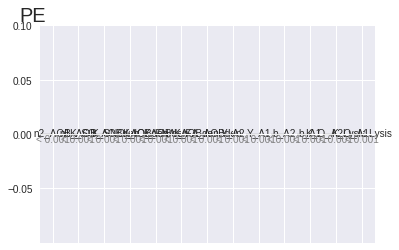

In [16]:
#evaluate sensitivity
goat.Calc_sensitivity(np.array(results['.Aer_Anox_ZP.C(S_N2O)']).T)
#transform sensitivity into ranking
goat.Get_ranking() 

#plot the partial effect based sensitivity
fig, ax1 = goat.plotsens(indice='PE', ec='grey',fc='grey')
# fig.set_size_inches(10, 10)
ax1.set_ylim(-0.1,0.1);

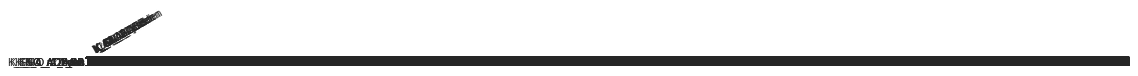

In [12]:
#plot the rankmatrix
fig, ax = goat.plot_rankmatrix(columns)
fig.set_size_inches(18.5, 10.5)